# *Predicting Customer Purchase Behavior*

**Authors:** Astrid Castro & Karli Balzanto

**Kaggle Dataset:** https://www.kaggle.com/datasets/rabieelkharoua/predict-customer-purchase-behavior-dataset

**Dataset Summary:** The dataset contains information on customer purchase behavior across various attributes, aiming to help data scientists and analysts understand the factors influencing purchase decisions. It includes demographic information, purchasing habits, and other relevant features. It is great because it enables various analyses such as classification, clustering, and regression tasks to predict and understand consumer purchase behaviour. 

**Research Question:** Can a neural network accurately predict whether a customer will make a purchase based on demographic data and high-level interaction metrics?

### Imports

In [33]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
roc_auc_score, classification_report, confusion_matrix)
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

### Let's look at the Data!

In [34]:
data = pd.read_csv("../data/customer_purchase_data.csv")
data.head()

,Age,Gender,AnnualIncome,NumberOfPurchases,ProductCategory,TimeSpentOnWebsite,LoyaltyProgram,DiscountsAvailed,PurchaseStatus
0,40,1,66120.267939,8,0,30.568601,0,5,1
1,20,1,23579.773583,4,2,38.240097,0,5,0
2,27,1,127821.306432,11,2,31.633212,1,0,1
3,24,1,137798.623120,19,3,46.167059,0,4,1
4,31,1,99300.964220,19,1,19.823592,0,0,1


In [35]:
print("Shape:", data.shape)
print("Columns:", data.columns)
data.isnull().sum()

Shape: (1500, 9)
Columns: Index(['Age', 'Gender', 'AnnualIncome', 'NumberOfPurchases', 'ProductCategory',
       'TimeSpentOnWebsite', 'LoyaltyProgram', 'DiscountsAvailed',
       'PurchaseStatus'],
      dtype='object')


Age                   0
Gender                0
AnnualIncome          0
NumberOfPurchases     0
ProductCategory       0
TimeSpentOnWebsite    0
LoyaltyProgram        0
DiscountsAvailed      0
PurchaseStatus        0
dtype: int64

The dataset contains **9 columns and 1,500 rows**. And we have **no NA's**. We will be using all variables and rows for our prediction

# Let's visualize some information corresponding to our dataset

For instance, we can show how many customers fall into each category for `PurchaseStatus`. Here, we can check how many customers made a purchase (1) or did not (0).

We do this to check for *class imbalance* and avoid issues during training.

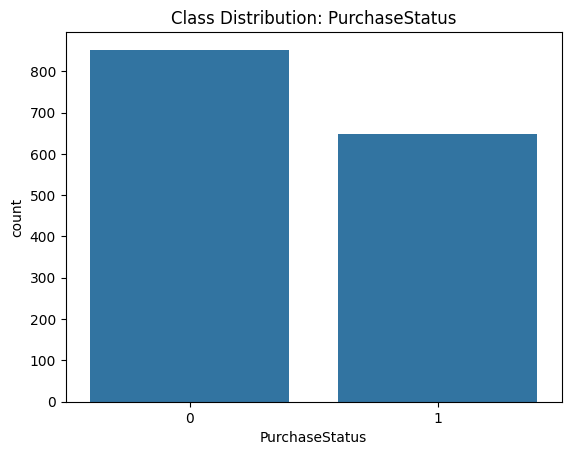

PurchaseStatus
0    852
1    648
Name: count, dtype: int64


In [5]:
sns.countplot(data=data, x="PurchaseStatus")
plt.title("Class Distribution: PurchaseStatus")
plt.show()

print(data['PurchaseStatus'].value_counts())

As we can see, the dataset is fairly balanced. With a 56.8% of people who did not make a purchase and 43.2% who did. Because neither class dominates, we do not need to apply resampling methods, and go as normal with our prediction.

Following, we can take a look at our **numeric variables**

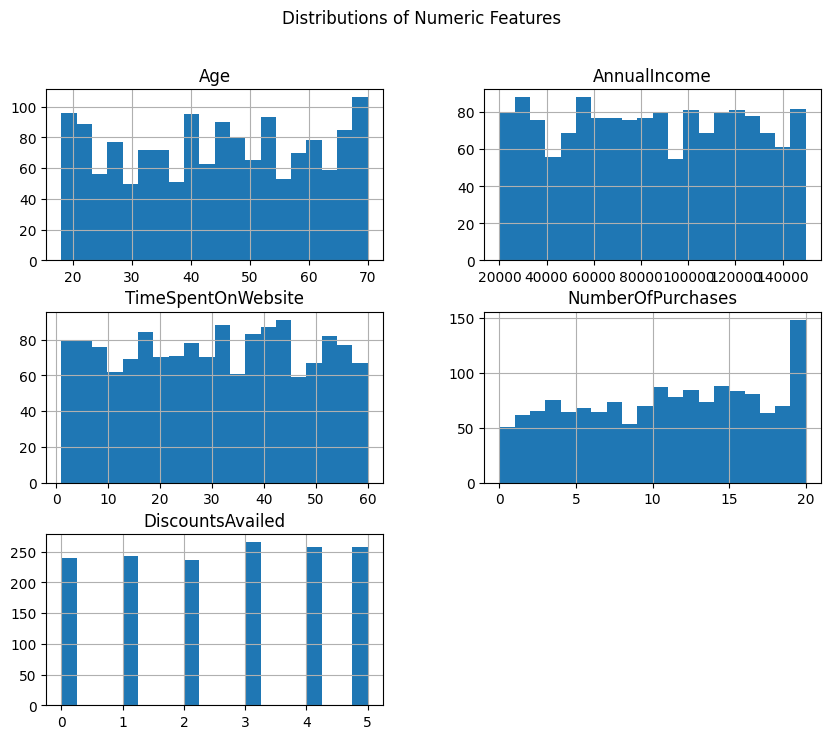

In [6]:
numeric_cols = ["Age", 
                "AnnualIncome", 
                "TimeSpentOnWebsite", 
                "NumberOfPurchases",
               "DiscountsAvailed"]

data[numeric_cols].hist(figsize=(10,8), bins=20)
plt.suptitle("Distributions of Numeric Features")
plt.show()

Lastly, we can check a correlation map of all variables, including `PurchaseStatus`

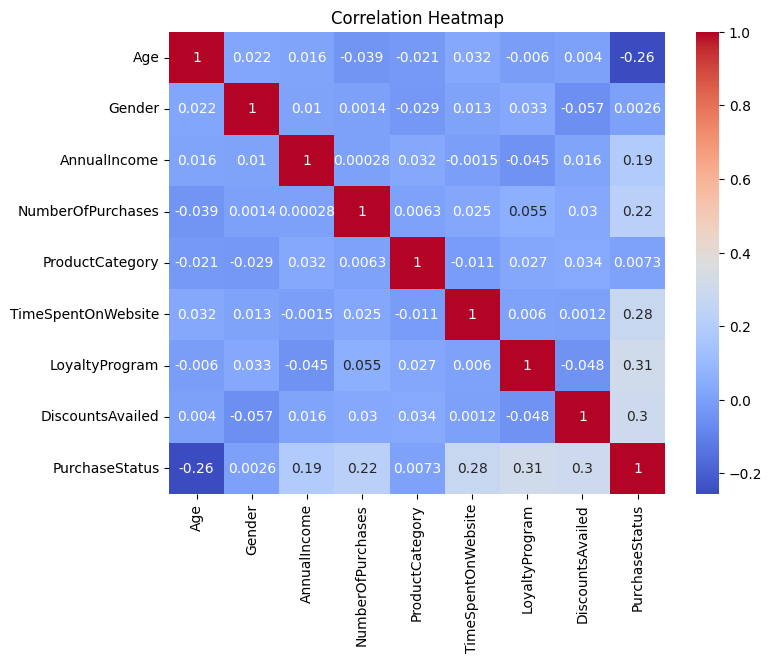

In [7]:
plt.figure(figsize=(8,6))
sns.heatmap(data.corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

With all of our numeric variables and given their correlation score, we can assume that:

- `TimeSpentOnWebsite`: Customers who spend more time on the website are more likely to purchase +0.28

- `LoyaltyProgram` members tend to purchase more +0.31

- `DiscountsAvailed`: Customers who use discounts are more likely to convert +0.30

- `NumberOfPurchases`: Past purchasing behaviour predicts purchases +0.22

These are moderate correlations, but show meaningful patterns. 

When it comes to non-numeric variables, we see that `Age`, `Gender` and `ProductCategory` have none or a very weak correlation to `PurchaseStatus`

# Time to Predict!


In [9]:
# Column Names
features = [
    "Age",
    "Gender",
    "AnnualIncome",
    "NumberOfPurchases",
    "ProductCategory",
    "TimeSpentOnWebsite",
    "LoyaltyProgram",
    "DiscountsAvailed"]
target = "PurchaseStatus"

X = data[features].values
y = data[target].values

Splitting the data ensures the model is evaluated on data it has not seen before.

In [10]:
# Split Data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y)

Next we scaled the features to make sure no variable dominates the others. 

Also helps the neural network train more smoothly.

In [ ]:
# Scale Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Neural Network Model

In [20]:
# Build NN
def build_model(input_dim):
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(16, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(8, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model
    
input_dim = X_train_scaled.shape[1]
model = build_model(input_dim)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 32)                288       
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 16)                528       
                                                                 
 dropout_3 (Dropout)         (None, 16)                0         
                                                                 
 dense_6 (Dense)             (None, 8)                 136       
                                                                 
 dense_7 (Dense)             (None, 1)                 9         
                                                                 
Total params: 961 (3.75 KB)
Trainable params: 961 (3.7

From here we can see that the model is a sequential neural network with four dense layers and two dropout layers, totaling 961 trainable parameters.

It begins with a 32-unit dense layer, followed by dropout to reduce overfitting.

The network then compresses information through 16-unit and 8-unit dense layers, each followed by dropout, and finally outputs a single value using a 1-unit dense layer suitable for regression.

All parameters in the model are trainable, meaning the network updates every weight during training, and because the model is relatively small, there's less risk of overfitting. 

In [21]:
# Callbacks
early_stop = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=8,
    restore_best_weights=True)

We included an EarlyStopping callback that monitors validation loss and stops training if it does not improve for 8 epochs.

This prevents overfitting and unnecessary training.

The model also restores the best-performing weights, ensuring the final model is the most accurate one observed during training.

---------------------------------------------------------------


Now on to the training. 

This is where the model learns by adjusting its weights based on the training data.

It minimizes error over many iterations.

In [22]:
# Train Model
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.15,
    epochs=100,
    batch_size=32,
    callbacks=[early_stop],
    verbose=2)

Epoch 1/100


2025-12-07 10:20:20.143220: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


32/32 - 1s - loss: 0.7697 - accuracy: 0.5843 - val_loss: 0.5528 - val_accuracy: 0.7278 - 1s/epoch - 36ms/step
Epoch 2/100
32/32 - 0s - loss: 0.5784 - accuracy: 0.6961 - val_loss: 0.4916 - val_accuracy: 0.7944 - 239ms/epoch - 7ms/step
Epoch 3/100
32/32 - 0s - loss: 0.5250 - accuracy: 0.7324 - val_loss: 0.4692 - val_accuracy: 0.8111 - 235ms/epoch - 7ms/step
Epoch 4/100
32/32 - 0s - loss: 0.5056 - accuracy: 0.7608 - val_loss: 0.4514 - val_accuracy: 0.8167 - 232ms/epoch - 7ms/step
Epoch 5/100
32/32 - 0s - loss: 0.4884 - accuracy: 0.7647 - val_loss: 0.4418 - val_accuracy: 0.8056 - 228ms/epoch - 7ms/step
Epoch 6/100
32/32 - 0s - loss: 0.4645 - accuracy: 0.7912 - val_loss: 0.4386 - val_accuracy: 0.7944 - 233ms/epoch - 7ms/step
Epoch 7/100
32/32 - 0s - loss: 0.4727 - accuracy: 0.7843 - val_loss: 0.4381 - val_accuracy: 0.8000 - 218ms/epoch - 7ms/step
Epoch 8/100
32/32 - 0s - loss: 0.4683 - accuracy: 0.7843 - val_loss: 0.4394 - val_accuracy: 0.7889 - 246ms/epoch - 8ms/step
Epoch 9/100
32/32 - 0s

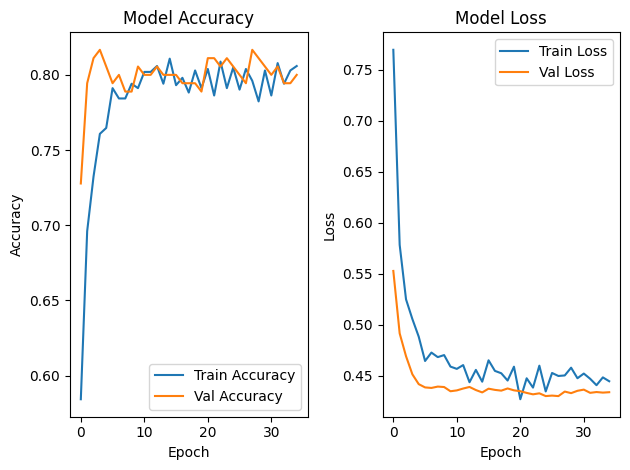

In [23]:
# Visual Representation
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

These plots show how accuracy and loss change during training & helps you see if the model is improving or overfitting.

---------------------------------------------------------------


Next we use the trained model to make predictions on the test set and then calculates metrics like accuracy, precision, recall, F1 score, and ROC AUC.

These results show how well the model actually performs on new data—such as how often it predicts correctly (accuracy), how reliable its positive predictions are (precision), how many real positives it captures (recall), and the balance between precision and recall (F1).

The classification report breaks down these metrics for each class to show where the model performs strongly or struggles.

In [24]:
# Predict & Evaluate
y_proba = model.predict(X_test_scaled).ravel()
y_pred = (y_proba >= 0.5).astype(int)

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
roc = roc_auc_score(y_test, y_proba)

print("\n--- MODEL PERFORMANCE ---")
print(f"Accuracy:      {acc:.4f}")
print(f"Precision:     {prec:.4f}")
print(f"Recall:        {rec:.4f}")
print(f"F1 Score:      {f1:.4f}")
print(f"ROC AUC:       {roc:.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred, zero_division=0))

10/10 [==============================] - 0s 2ms/step

--- MODEL PERFORMANCE ---
Accuracy:      0.8300
Precision:     0.8376
Recall:        0.7538
F1 Score:      0.7935
ROC AUC:       0.8989

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.89      0.86       170
           1       0.84      0.75      0.79       130

    accuracy                           0.83       300
   macro avg       0.83      0.82      0.82       300
weighted avg       0.83      0.83      0.83       300



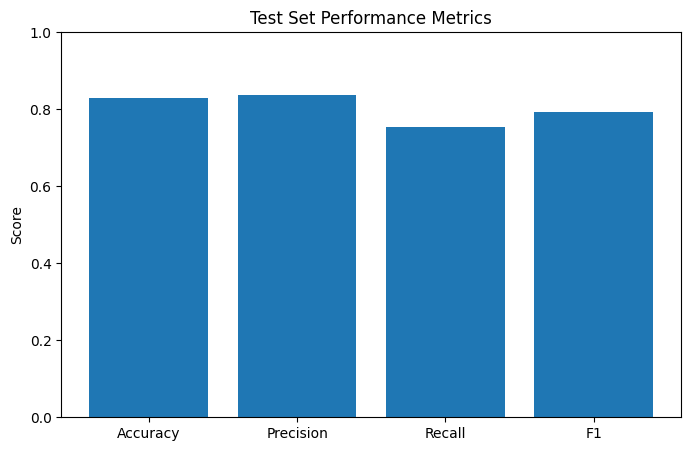

In [25]:
#Bar Chart of Final Test
plt.figure(figsize=(8,5))
metrics = ["Accuracy", "Precision", "Recall", "F1"]
values = [acc, prec, rec, f1]

plt.bar(metrics, values)
plt.ylim(0,1)
plt.title("Test Set Performance Metrics")
plt.ylabel("Score")
plt.show()

The bar chart gives a simple visual summary of key test metrics, making comparison between them easier.

From the bar chart:
- Accuracy: shows the overall percentage of test samples the model predicted correctly.
    - *0.82* = model correctly classified 82% of all customers as either purchasing or not purchasing
- Precision: measures how often the model's positive predictions were actually correct.
    - *0.8333* = when the model predicted a customer will purchase, it was correct about 83% of the time.
    - High precision means fewer false positives
- Recall: measures how many of the actual purchasers the model successfully identified.
    - *0.7308* = model found about 73% of all real purchasers.
    - Higher recall means fewer missed buyers (fewer false negatives)
- F1: represents a balance between precision and recall.
    - *0.7787* = model has a reasonable trade-off between catching real purchasers (recall) and being correct when it predicts a purchase (precision).
    - It’s useful when you want both errors—false positives and false negatives—to matter.

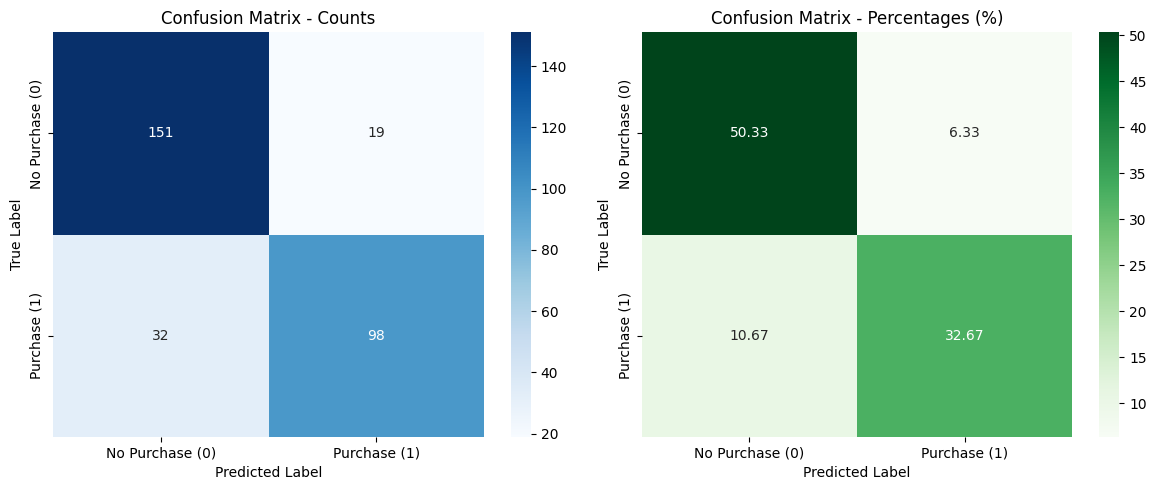

In [26]:
# Confusion Matrix - count & percentage
cm = confusion_matrix(y_test, y_pred)
cm_percent = cm / cm.sum() * 100   # convert to %

fig, axes = plt.subplots(1, 2, figsize=(12,5))

# left: counts
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap="Blues",
    xticklabels=["No Purchase (0)", "Purchase (1)"],
    yticklabels=["No Purchase (0)", "Purchase (1)"],
    ax=axes[0]
)
axes[0].set_title("Confusion Matrix - Counts")
axes[0].set_ylabel("True Label")
axes[0].set_xlabel("Predicted Label")

# right: percentages
sns.heatmap(
    cm_percent,
    annot=True,
    fmt='.2f',
    cmap="Greens",
    xticklabels=["No Purchase (0)", "Purchase (1)"],
    yticklabels=["No Purchase (0)", "Purchase (1)"],
    ax=axes[1]
)
axes[1].set_title("Confusion Matrix - Percentages (%)")
axes[1].set_ylabel("True Label")
axes[1].set_xlabel("Predicted Label")

plt.tight_layout()
plt.show()

The confusion matrixes shows where the model is correct or incorrect.

It helps identify errors like false positives & false negatives.

### Findings

In [32]:
# Statistical Summary & Conclusion

print("SUMMARY:")
print(f"  The model achieved an accuracy of {acc:.2f}, correctly predicting purchase behavior "
      f"for about {acc*100:.0f}% of customers. \n  Precision was {prec:.2f}, indicating the model predicted "
      f"a purchase corectly abour {prec*100:.0f}% of the time. \n  Recall was {rec:.2f}, showing the model "
      f"successfully identified about {rec*100:.0f}% of actual purchasers. \n  The F1-score of {f1:.2f} reflects a "
      f"balanced trade-off between precision and recall. \n  The ROC AUC of {roc:.2f} suggests the model can "
      f"reasonably tell between purchasers and non-purchasers across different thresholds.\n")

# automatic
if roc >= 0.80:
    conclusion = (
        "  Overall, the neural network demonstrates strong predictive performance. "
        "\n  The model not only separates purchasers from non-purchasers well (high ROC AUC), "
        "\n  but also maintains solid precision and recall. This indicates that the available "
        "\n  customer features contain meaningful patterns for predicting purchase behavior."
    )
elif roc >= 0.70:
    conclusion = (
        "  Overall, the model shows moderate predictive performance. "
        "\n  It captures some meaningful patterns in the data but still misses a noticeable portion of "
        "\n  actual purchasers. Improving feature engineering, adding more predictive variables, or "
        "\n  tuning the neural network may help increase recall and overall discrimination."
    )
else:
    conclusion = (
        "  Overall, the model demonstrates weak predictive performance. "
        "\n  Although accuracy is reasonable, the lower recall and ROC AUC suggest that the features "
        "\n  in the dataset do not strongly predict purchasing behavior. Additional or more informative "
        "\n  features, feature engineering, or alternative modeling approaches may be required."
    )

print("\nCONCLUSION: ")
print(conclusion)


SUMMARY:
  The model achieved an accuracy of 0.83, correctly predicting purchase behavior for about 83% of customers. 
  Precision was 0.84, indicating the model predicted a purchase corectly abour 84% of the time. 
  Recall was 0.75, showing the model successfully identified about 75% of actual purchasers. 
  The F1-score of 0.79 reflects a balanced trade-off between precision and recall. 
  The ROC AUC of 0.90 suggests the model can reasonably tell between purchasers and non-purchasers across different thresholds.


CONCLUSION: 
  Overall, the neural network demonstrates strong predictive performance. 
  The model not only separates purchasers from non-purchasers well (high ROC AUC), 
  but also maintains solid precision and recall. This indicates that the available 
  customer features contain meaningful patterns for predicting purchase behavior.


# Further Applications

Once trained, our model can be used to predict future customer purchasing behavior, allowing economic researchers and businesses to forecast demand, simulate policy changes, optimize marketing strategies, and estimate customer lifetime value. This turns raw demographic and interaction data into actionable economic insights

For example: **Predicting Individual Customer Purchase Probability (Future Purchases)**

Once trained, the model can take new customers or new behavior data and output:

Will buy -> 1

Will not buy -> 0

- Economists and marketers can use these probabilities to:

- Forecast expected revenue

- Estimate demand for upcoming months

- Identify high-value customers before they buy

- Target promotions only to customers with low purchase probability

This is literally how Amazon, Netflix, and Target run parts of their economic forecasting.